In [1]:
%pip install -q git+https://github.com/yfukai/BaSiCPy@autosegment
%pip install -q imagecodecs

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 44.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import re
from skimage.io import imread
from skimage import filters
import pandas as pd
from basicpy import BaSiC

In [4]:
image_dir = Path(
    "/content/drive/MyDrive/Colab Notebooks/BaSiCPy/3DLightsheetfromAli/mouse_brain_raw_scans"
)
!ls "$image_dir"

CD1-15_Z1000-1009  CD1-41_Z1000-1009  CD1-42_Z1000-1009  test_onezslice


=============== /content/drive/MyDrive/Colab Notebooks/BaSiCPy/3DLightsheetfromAli/mouse_brain_raw_scans/CD1-42_Z1000-1009 ===============


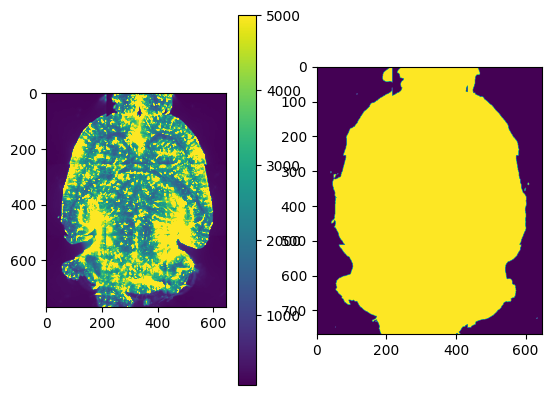

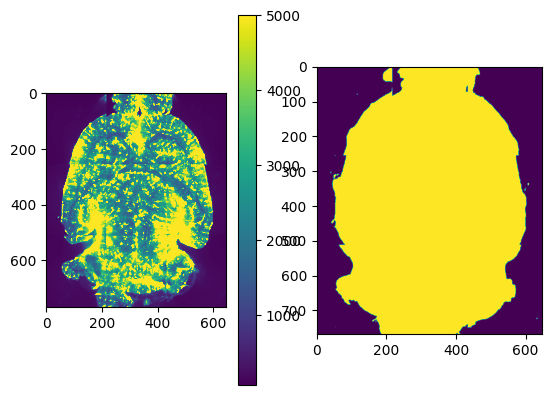

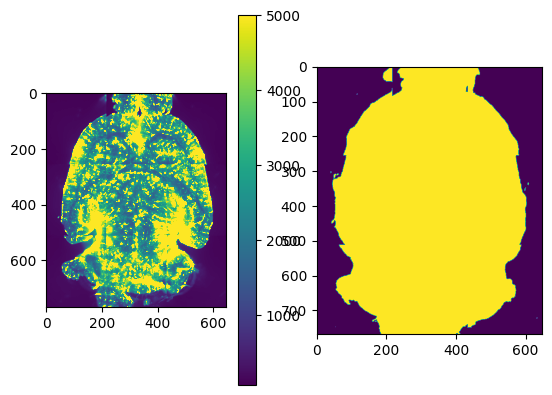

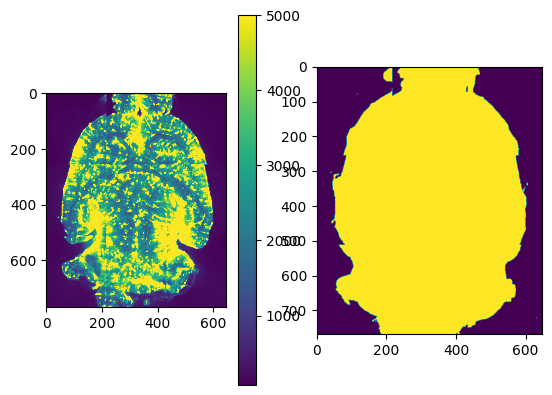

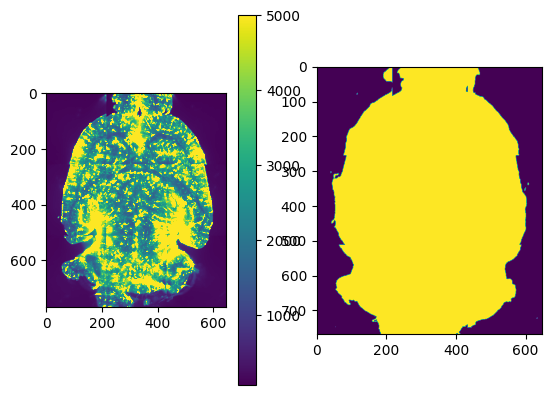

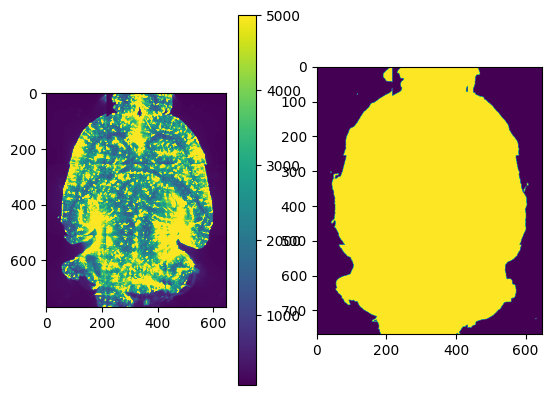

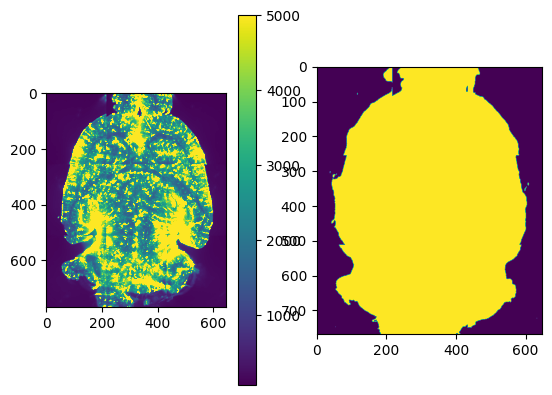

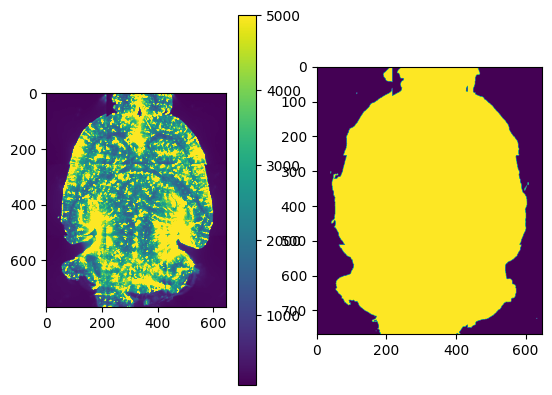

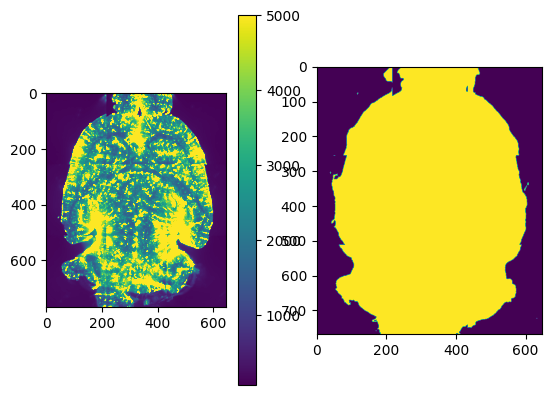

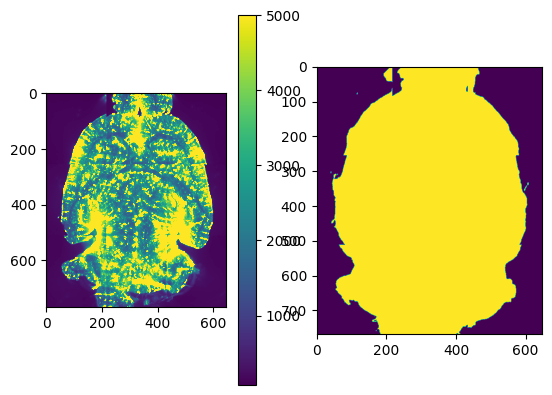

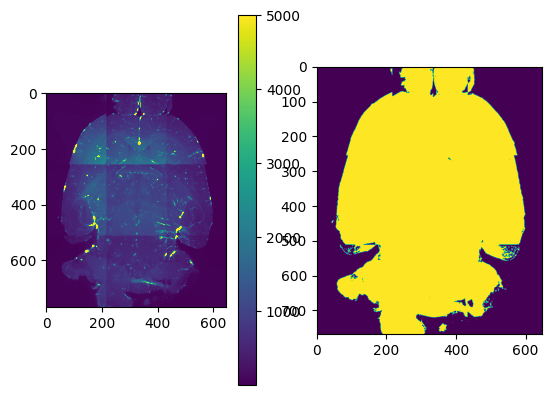

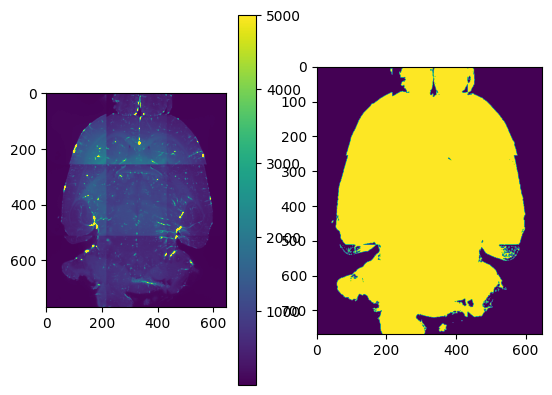

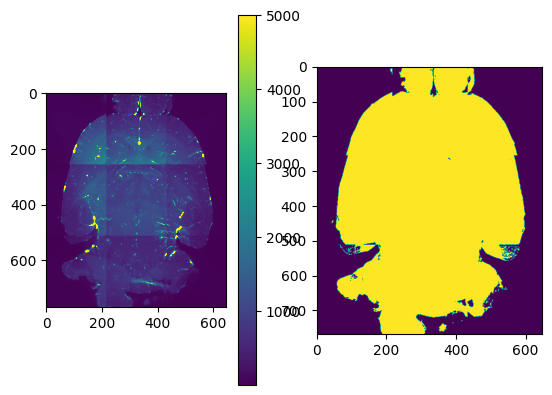

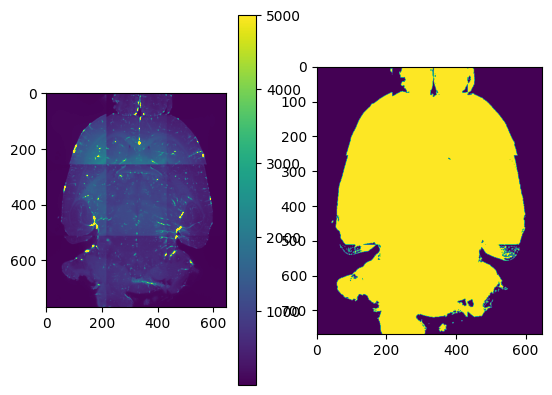

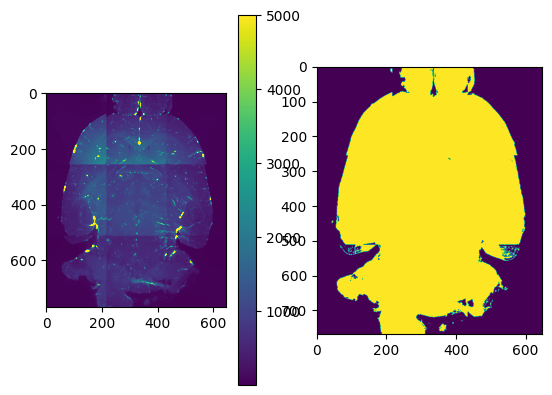

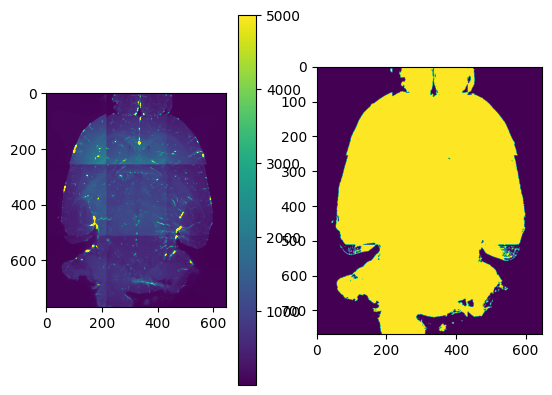

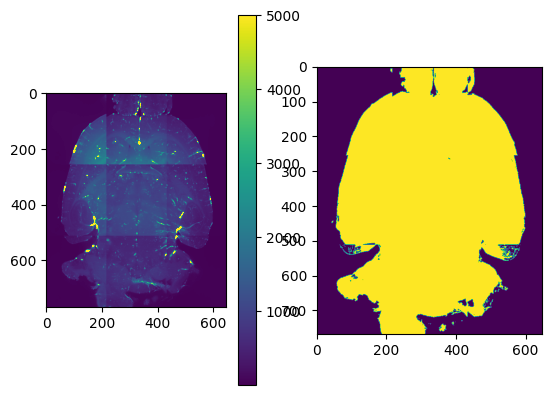

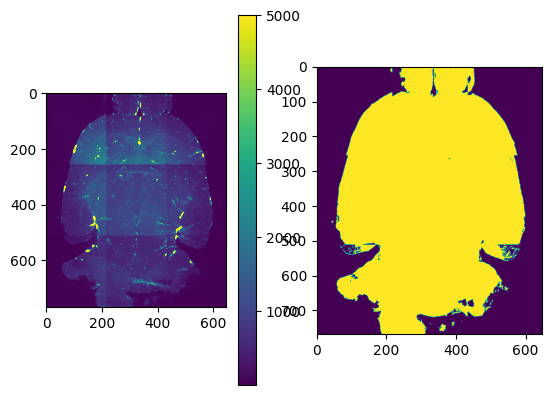

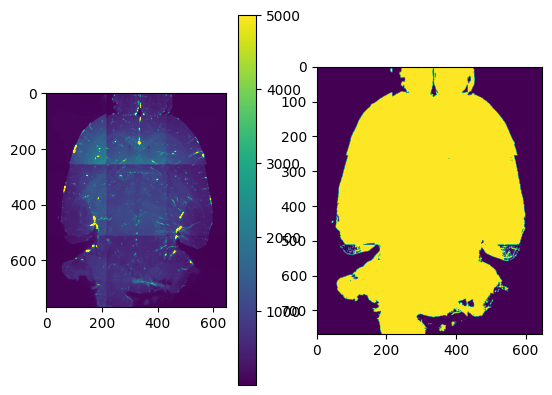

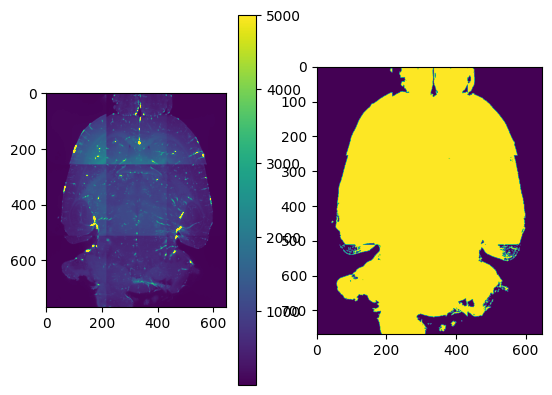

[0] fit_and_calc_entropy (Hill Climbing):  23%|──        | 23/100 [01:35<05:21,  4.17s/it, best_iter=0, best_pos=[15], best_score=-11.219465366231653]




Results: 'fit_and_calc_entropy'  
   Best score: -11.219465366231653  
   Best parameter set:
      'smoothness_flatfield' : 14.38449888287663  
   Best iteration: 0  
 
   Random seed: 897123669  
 
   Evaluation time   : 95.70145225524902 sec    [99.99 %]
   Optimization time : 0.008086681365966797 sec    [0.01 %]
   Iteration time    : 95.70953893661499 sec    [1.04 iter/sec]
 


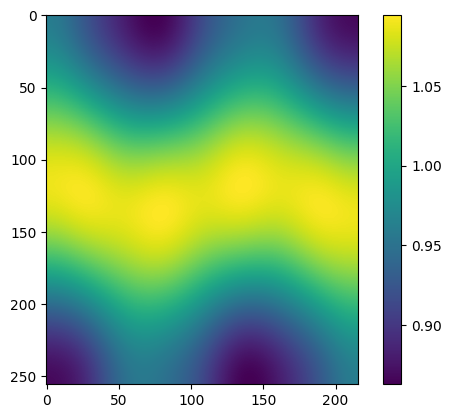

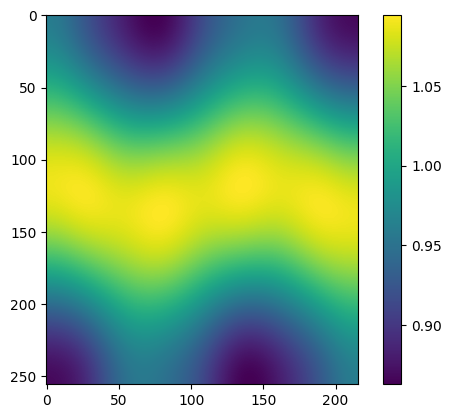

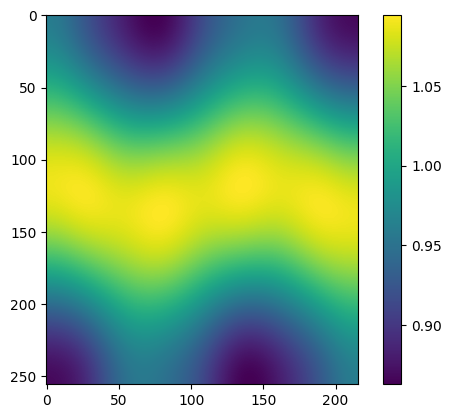

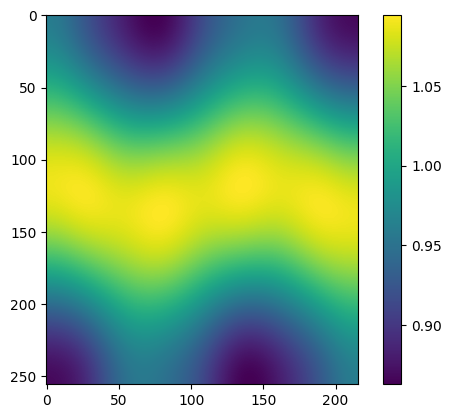

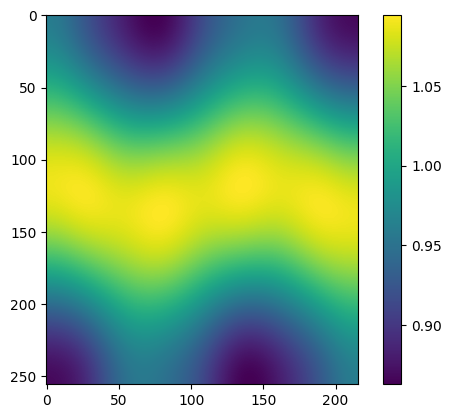

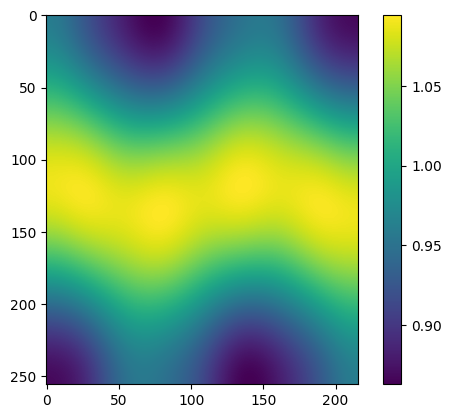

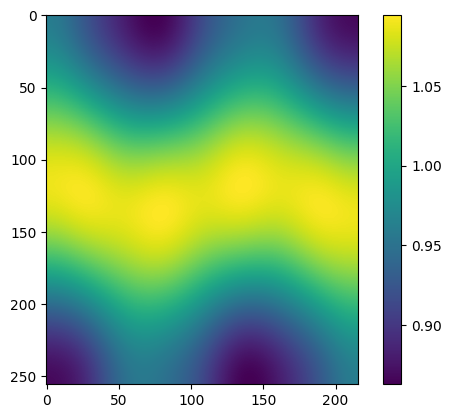

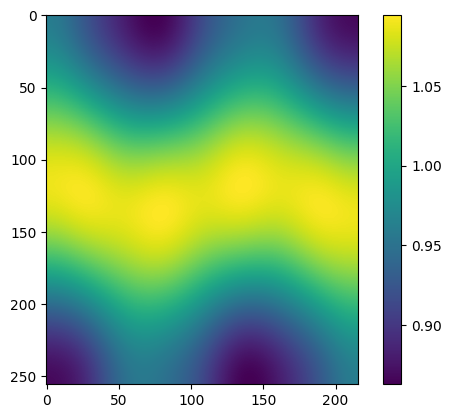

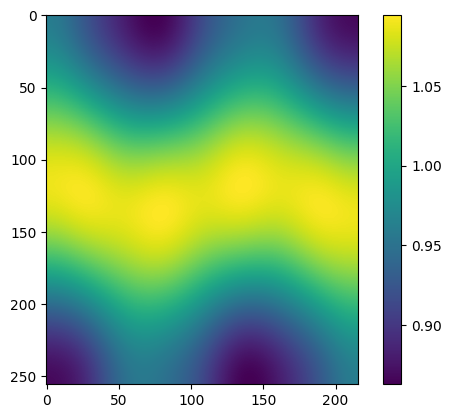

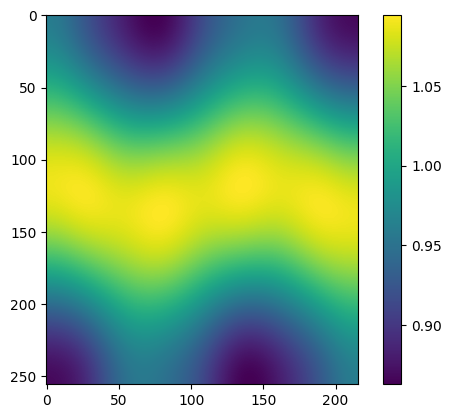

[0] fit_and_calc_entropy (Hill Climbing):  30%|───       | 30/100 [00:20<00:47,  1.47it/s, best_iter=0, best_pos=[14], best_score=-10.828460189580174]




Results: 'fit_and_calc_entropy'  
   Best score: -10.828460189580174  
   Best parameter set:
      'smoothness_flatfield' : 8.858667904100823  
   Best iteration: 0  
 
   Random seed: 930437271  
 
   Evaluation time   : 20.06926393508911 sec    [99.95 %]
   Optimization time : 0.009342670440673828 sec    [0.05 %]
   Iteration time    : 20.078606605529785 sec    [4.98 iter/sec]
 


[0] fit_and_calc_entropy (Hill Climbing):   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
th = 300

for subject_path in list(image_dir.glob("CD1-42*"))[-1:]:
    print("===============", subject_path, "===============")
    image_small = np.load(subject_path / "images_small.npy")
    image2 = np.reshape(
        image_small,
        [
            image_small.shape[0],
            image_small.shape[1] * image_small.shape[2],
            *image_small.shape[3:],
        ],
    )

    weights = image2 > th

    nC, nrow, ncol, nZ, nY, nX = image_small.shape
    for c in range(image2.shape[0]):
        for z in range(nZ):
            montage = np.zeros((nrow * nY, ncol * nX))
            montage2 = np.zeros((nrow * nY, ncol * nX))
            for row in range(nrow):
                for col in range(ncol):
                    montage[
                        row * nY : (row + 1) * nY, col * nX : (col + 1) * nX
                    ] = image_small[c, row, col, z]
                    montage2[row * nY : (row + 1) * nY, col * nX : (col + 1) * nX] = (
                        image_small[c, row, col, z] > th
                    )
            plt.subplot(121)
            plt.imshow(montage, vmax=5000)
            plt.colorbar()
            plt.subplot(122)
            plt.imshow(montage2)
            plt.show()

    flatfields = []
    fitting_params = []

    for c in range(image2.shape[0]):
        params = {"channel": c, "subject_path": subject_path}
        b = BaSiC(fitting_mode="ladmap", smoothness_flatfield=0.01)
        b.autotune(
            image2[c],
            weights[c],
            search_space={
                "smoothness_flatfield": list(np.logspace(-2, 2, 20, base=10))
            },
        )
        b.fit(image2[c], weights[c])
        for z in range(nZ):
            plt.imshow(b.flatfield[z])
            plt.colorbar()
            plt.show()
        flatfields.append(b.flatfield)
        fitting_params.append({"method": "3D", **params})

        b = BaSiC(fitting_mode="ladmap", smoothness_flatfield=0.01)
        flatfield_2d = []
        for z in range(nZ):
            if z == 0:
                b.autotune(
                    image2[c, :, z],
                    weights[c, :, z],
                    search_space={
                        "smoothness_flatfield": list(np.logspace(-2, 2, 20, base=10))
                    },
                )
            b.fit(image2[c, :, z], weights[c, :, z])
            flatfield_2d.append(b.flatfield)
        flatfields.append(np.array(flatfield_2d))
        fitting_params.append({"method": "2D", **params})

    np.save(subject_path / "flatfields.npy", flatfields)
    pd.DataFrame.from_records(fitting_params).to_csv(
        subject_path / "fitting_params.csv"
    )

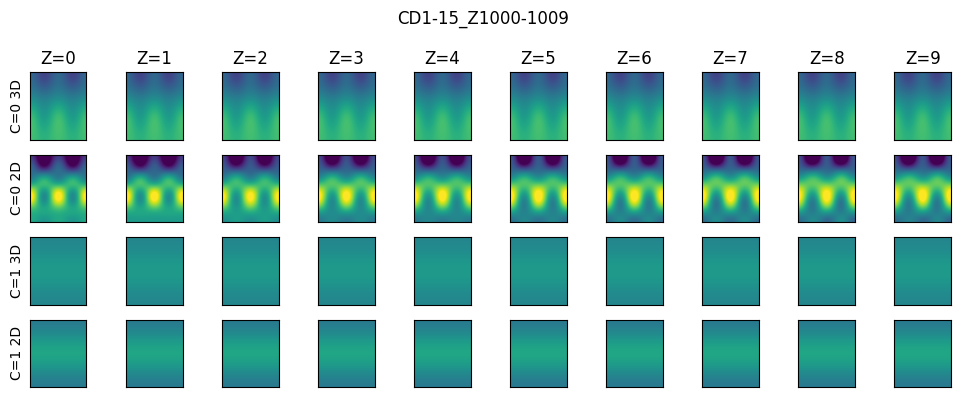

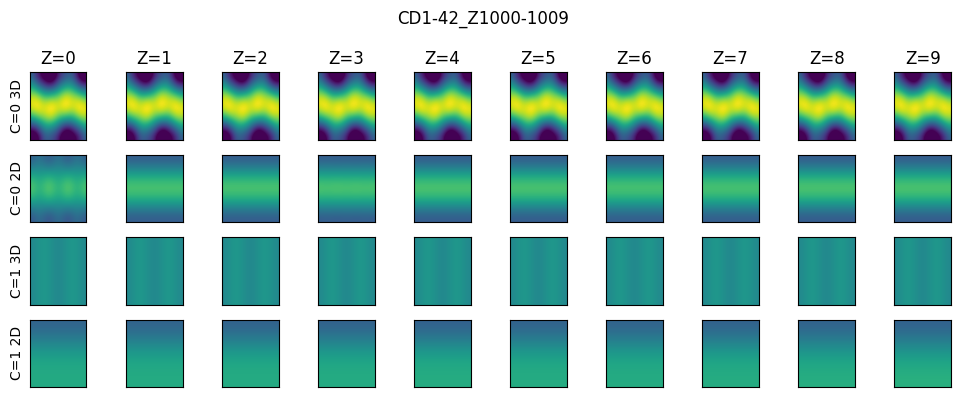

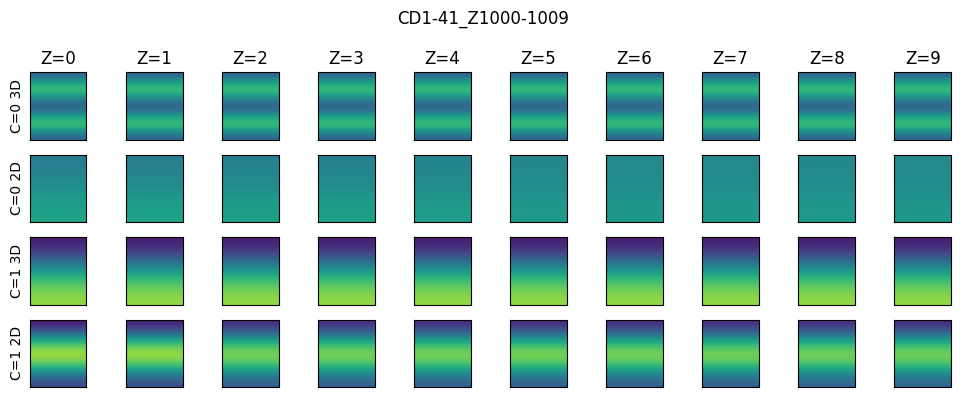

In [ ]:
for subject_path in list(image_dir.glob("CD*"))[:]:
    flatfields = np.load(subject_path / "flatfields.npy")
    fitting_params_df = pd.read_csv(subject_path / "fitting_params.csv")
    nsample, nZ = flatfields.shape[:2]
    fig, axes = plt.subplots(nsample, nZ, figsize=(nZ * 1, nsample * 1))
    for s in range(nsample):
        for z in range(nZ):
            axes[s, z].imshow(flatfields[s, z], vmin=0.9, vmax=1.1)
            axes[s, z].set_xticks([])
            axes[s, z].set_yticks([])
            if z == 0:
                row = fitting_params_df.iloc[s]
                axes[s, z].set_ylabel(f"C={row['channel']} {row['method']}")
            if s == 0:
                axes[s, z].set_title(f"Z={z}")
    fig.suptitle(subject_path.name)
    fig.tight_layout()
    fig.show()

In [ ]:
list(subject_path.glob("*.npy"))

[PosixPath('/content/drive/MyDrive/Colab Notebooks/BaSiCPy/3DLightsheetfromAli/mouse_brain_raw_scans/CD1-41_Z1000-1009/images.npy'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/BaSiCPy/3DLightsheetfromAli/mouse_brain_raw_scans/CD1-41_Z1000-1009/images_small.npy')]

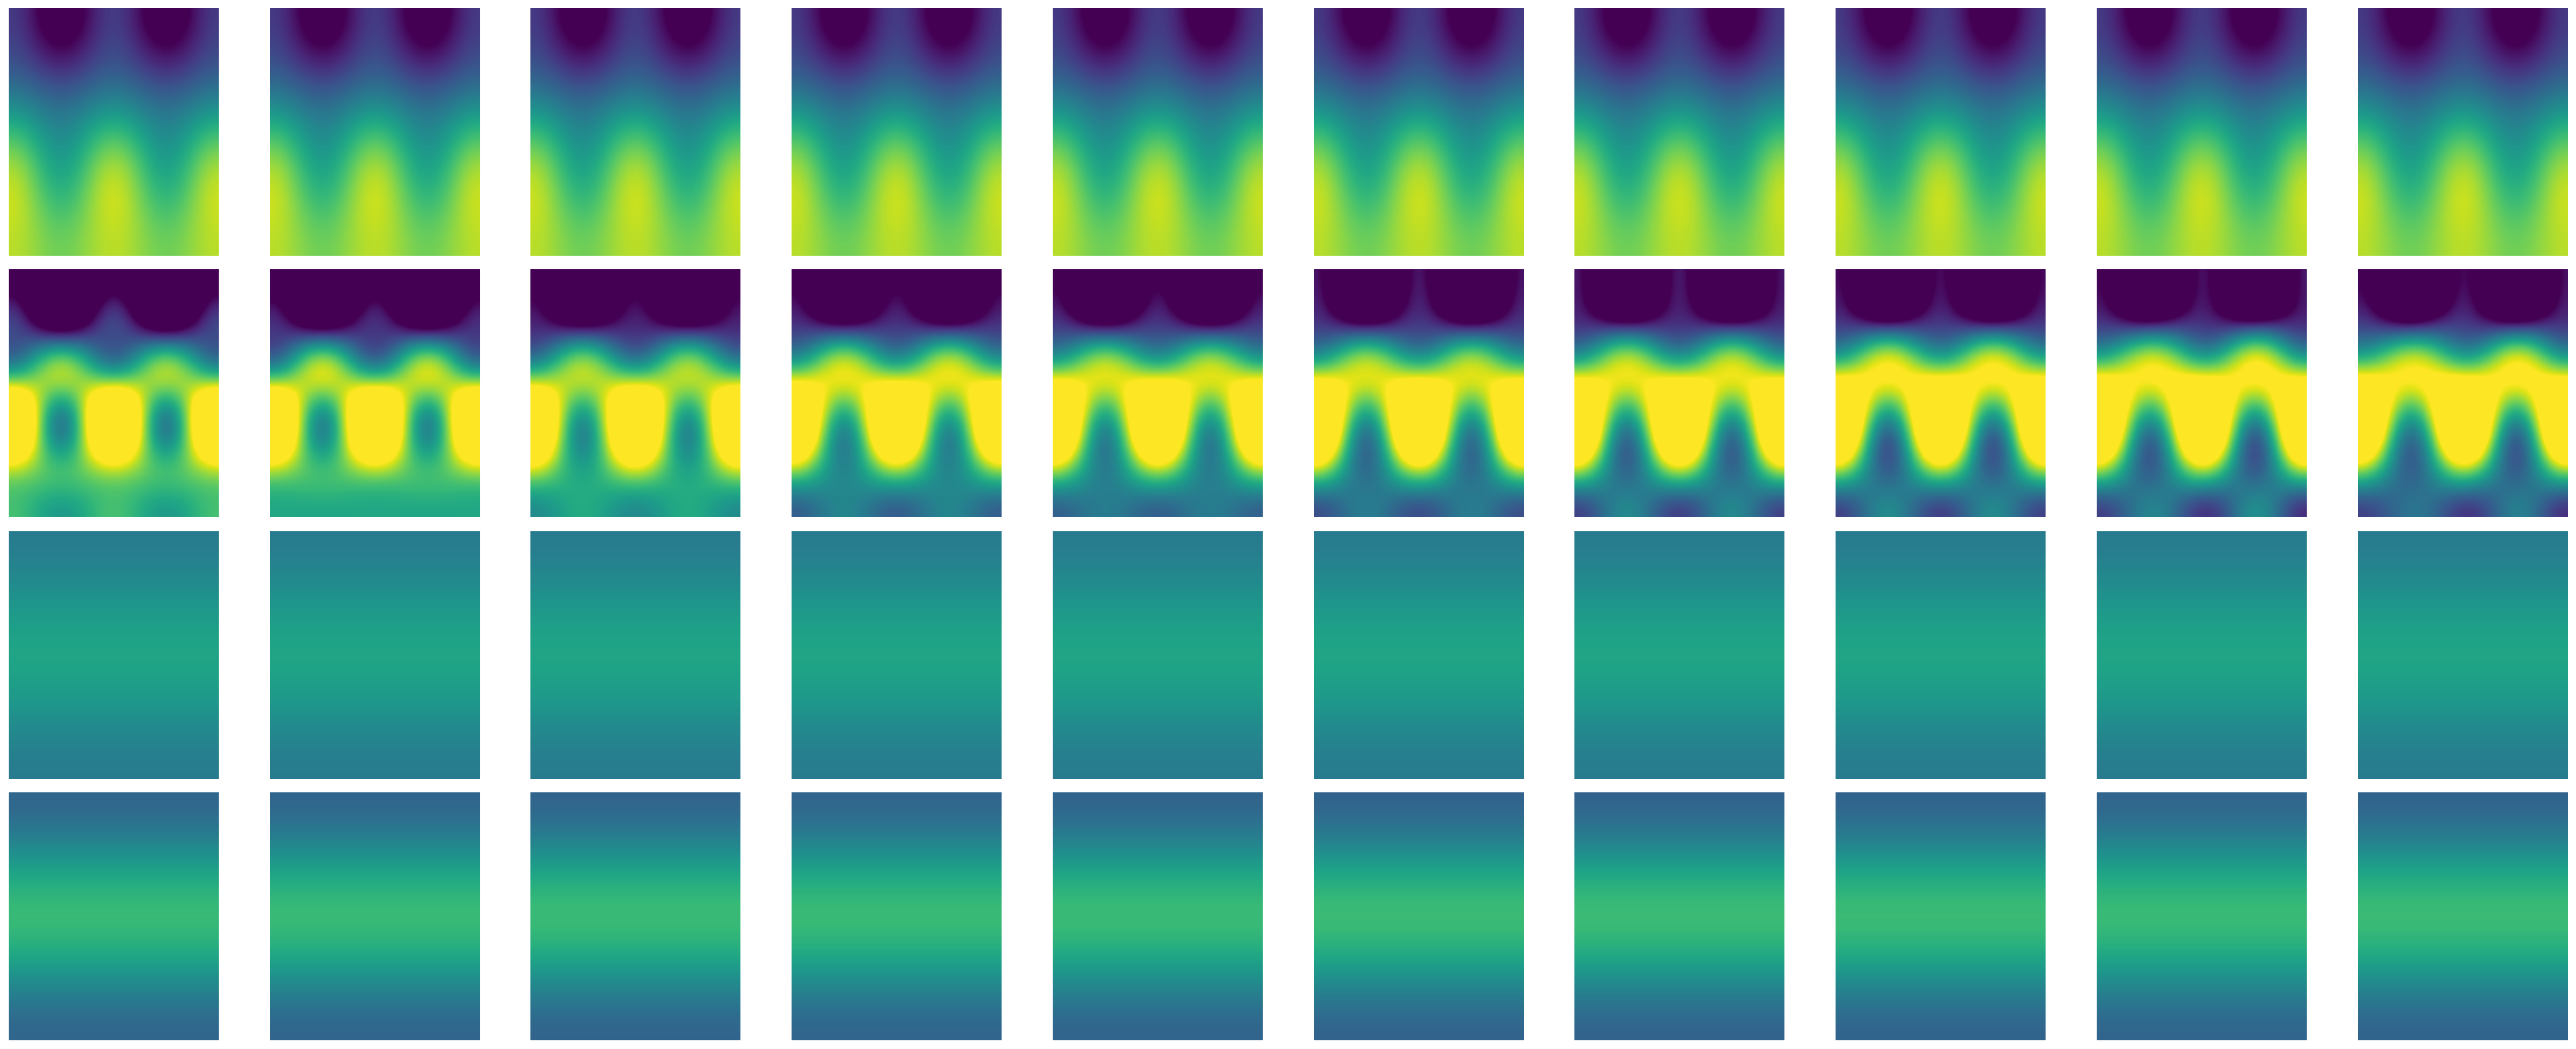